### Imports

In [49]:
%load_ext autoreload
%autoreload 2

from fermionic_mappings import jw_majoranas, bk_majoranas
from electronic_hamiltonian import quadratic_terms, quartic_terms
from qiskit.quantum_info import PauliList
from tableau import spread_node, spread_node_slice, anticommutation_matrix
from cost_functions import weight, quadratic_term_mean_weight, quartic_term_mean_weight
from annealing import anneal
import matplotlib.pyplot as plt
import numpy as np
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create Majorana Strings using Jordan-Wigner-Mapping or Bravyi-Kitaev-Mapping

In [57]:
N = 20

x, z = jw_majoranas(N)
# x, z, paulis = bk_majoranas(N)

paulis = PauliList.from_symplectic(z, x)

print("Majorana Operators:", paulis)

Majorana Operators: ['IIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIXZ', 'IIIIIIIIIIIIIIIIIXZZ',
 'IIIIIIIIIIIIIIIIXZZZ', 'IIIIIIIIIIIIIIIXZZZZ', 'IIIIIIIIIIIIIIXZZZZZ',
 'IIIIIIIIIIIIIXZZZZZZ', 'IIIIIIIIIIIIXZZZZZZZ', 'IIIIIIIIIIIXZZZZZZZZ',
 'IIIIIIIIIIXZZZZZZZZZ', 'IIIIIIIIIXZZZZZZZZZZ', 'IIIIIIIIXZZZZZZZZZZZ',
 'IIIIIIIXZZZZZZZZZZZZ', 'IIIIIIXZZZZZZZZZZZZZ', 'IIIIIXZZZZZZZZZZZZZZ',
 'IIIIXZZZZZZZZZZZZZZZ', 'IIIXZZZZZZZZZZZZZZZZ', 'IIXZZZZZZZZZZZZZZZZZ',
 'IXZZZZZZZZZZZZZZZZZZ', 'XZZZZZZZZZZZZZZZZZZZ', 'IIIIIIIIIIIIIIIIIIIY',
 'IIIIIIIIIIIIIIIIIIYZ', 'IIIIIIIIIIIIIIIIIYZZ', 'IIIIIIIIIIIIIIIIYZZZ',
 'IIIIIIIIIIIIIIIYZZZZ', 'IIIIIIIIIIIIIIYZZZZZ', 'IIIIIIIIIIIIIYZZZZZZ',
 'IIIIIIIIIIIIYZZZZZZZ', 'IIIIIIIIIIIYZZZZZZZZ', 'IIIIIIIIIIYZZZZZZZZZ',
 'IIIIIIIIIYZZZZZZZZZZ', 'IIIIIIIIYZZZZZZZZZZZ', 'IIIIIIIYZZZZZZZZZZZZ',
 'IIIIIIYZZZZZZZZZZZZZ', 'IIIIIYZZZZZZZZZZZZZZ', 'IIIIYZZZZZZZZZZZZZZZ',
 'IIIYZZZZZZZZZZZZZZZZ', 'IIYZZZZZZZZZZZZZZZZZ', 'IYZZZZZZZZZZZZZZZZZZ',
 'YZZZZZZZZZZZZZZZZZZZ']


### (Optional) Compute all possible quadratic and quartic terms

In [29]:
x_terms, z_terms = quadratic_terms(x, z, N)
quadratic_terms_paulis = PauliList.from_symplectic(z_terms, x_terms)

print("Quadratic Hamiltonian Terms:", quadratic_terms_paulis)

x_terms, z_terms = quartic_terms(x, z, N)
quartic_terms_paulis = PauliList.from_symplectic(z_terms, x_terms)

print("Quartic Hamiltonian Terms:", quartic_terms_paulis)

print(f"Average Weight: {weight(x, z)}")

Quadratic Hamiltonian Terms: ['IIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIY',
 'IIIIIIIIIIIIIIIIIIIIIIIZX', 'IIIIIIIIIIIIIIIIIIIIIIXYX',
 'IIIIIIIIIIIIIIIIIIIIIIYYX', 'IIIIIIIIIIIIIIIIIIIIIIZYX',
 'IIIIIIIIIIIIIIIIIIIIIZIXX', 'IIIIIIIIIIIIIIIIIIIXXYIXX',
 'IIIIIIIIIIIIIIIIIIIXYYIXX', 'IIIIIIIIIIIIIIIIIIIXZYIXX',
 'IIIIIIIIIIIIIIIIIIIYIYIXX', 'IIIIIIIIIIIIIIIIIIXZIYIXX',
 'IIIIIIIIIIIIIIIIIIYZIYIXX', 'IIIIIIIIIIIIIIIIIIZZIYIXX',
 'IIIIIIIIIIIIIIIIIZIIIXIXX', 'IIIIIIIIIIIIIXIXXYIIIXIXX',
 'IIIIIIIIIIIIIXIXYYIIIXIXX', 'IIIIIIIIIIIIIXIXZYIIIXIXX',
 'IIIIIIIIIIIIIXIYIYIIIXIXX', 'IIIIIIIIIIIIIXXZIYIIIXIXX',
 'IIIIIIIIIIIIIXYZIYIIIXIXX', 'IIIIIIIIIIIIIXZZIYIIIXIXX',
 'IIIIIIIIIIIIIYIIIYIIIXIXX', 'IIIIIIIIIIIXXZIIIYIIIXIXX',
 'IIIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIZY',
 'IIIIIIIIIIIIIIIIIIIIIIXYY', 'IIIIIIIIIIIIIIIIIIIIIIYYY',
 'IIIIIIIIIIIIIIIIIIIIIIZYY', 'IIIIIIIIIIIIIIIIIIIIIZIXY',
 'IIIIIIIIIIIIIIIIIIIXXYIXY', 'IIIIIIIIIIIIIIIIIIIXYYIXY',
 'IIIIIIIIIIIIIIIIIIIXZYIXY

### Optimizing Fermionic Mappings with Simulated Annealing

To assess the quality of a fermionic mapping, we compute the average cost to implement any quartic or quadratic fermionic terms on a quantum computer. Assuming all-to-all connectivity for the sake of simplicity, this optimization tasks simply boils down to minimizing the average weight/locality of the strings associated with the fermionic operators.

For an $N$ mode system, based on a set of $2N$ mutually anti-commuting Pauli strings, one can straightforwardly define a "neighborhood" of fermionic. Elements from this neighborhood are attained by applying a specific rule to the Majorana strings. More explicitly, assuming some solution with strings $P_1, P_2, \dots, P_{2N}$, one can pick any string $P_j$ and multiply all other strings with it, therefore $P_i \to P_i P_j$ for $i \neq j$. One can easily verify that this rule preserves of structure of the underlying anticommutation graph, and therefore provides another valid fermion-to-qubit mapping. We use this rule as an exploration strategy in the annealer (in our code its called "spread_node"). 

In details, this works as follows:

1. Start from the Majorana Pauli strings from a known fermionic mapping. In this work, we restrict ourselves to the Jordan-Wignger (JW) and Bravyi-Kitaev (BK) mapping. 
2. To optimize 

### Justification of the approximative cost function

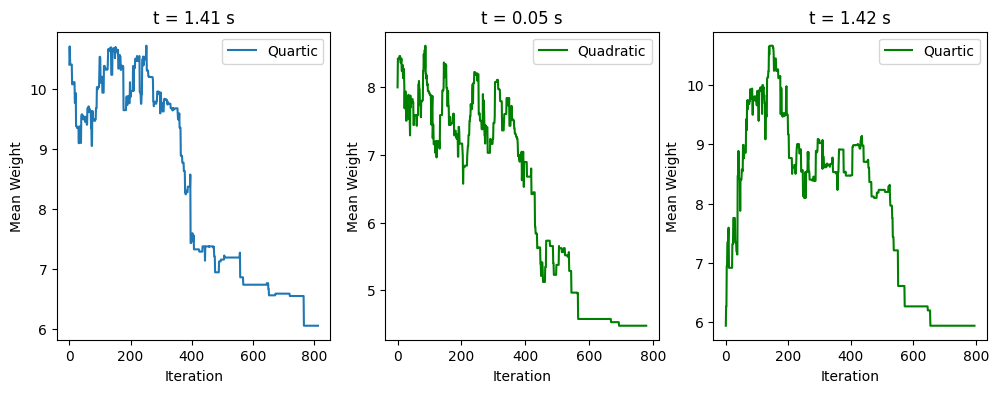

In [58]:
cooling_rate = 0.995
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Run the optimization with the quartic (expensive) cost function
start = time.time()
x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quartic_term_mean_weight, cooling_rate=cooling_rate)
end = time.time()
elapsed_seconds = end - start

axs[0].plot(energies, label="Quartic")
axs[0].set_title(f"t = {elapsed_seconds:.2f} s")

# Reset to the JW strings and instead first run a cheaper quadratic optimization
x, z = jw_majoranas(N)

start = time.time()
x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=cooling_rate)   
end = time.time()
elapsed_seconds = end - start

axs[1].plot(energies, label="Quadratic", color="green")
axs[1].set_title(f"t = {elapsed_seconds:.2f} s")

# Use the result from the quadratic optimization as an input for the more expensive quartic optimization
start = time.time()
x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quartic_term_mean_weight, cooling_rate=cooling_rate)
end = time.time()
elapsed_seconds = end - start

axs[2].plot(energies, label="Quartic", color="green")
axs[2].set_title(f"t = {elapsed_seconds:.2f} s")

for ax in axs:
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Mean Weight")
    ax.legend()

### Locality Analysis starting from JW mapping

Here, we consider the JW mapping for various problem sizes up to 160 qubits. For each instance, we run our simulated annealing protocol and optimize w.r.t. the average weight of quadratic terms. Based on the optimized results, we recover the average weight of quartic terms, as motivated in the previous section. 

In [ ]:
quadratic_weights = []
quartic_weights = []

quadratic_weights_jw = []
quartic_weights_jw = []

num_qubits = list(range(10, 161, 10))

for N in num_qubits:

    x, z = jw_majoranas(N)
    # Compute the Weights for the JW mapping (starting point)
    quadratic_weights_jw.append(quadratic_term_mean_weight(x, z))
    quartic_weights_jw.append(quartic_term_mean_weight(x, z))

    x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.9995)
    
    quadratic_weights.append(energy_opt)
    quartic_weights.append(quartic_term_mean_weight(x, z))

In [65]:
### Storing the results here for the optimizations based on JW to avoid running the cell above every time

num_qubits = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]

quadratic_weights_jw = np.array([4.666666666666667, 8.0, 11.333333333333334, 14.666666666666666, 18.0, 21.333333333333332, 24.666666666666668, 28.0, 31.333333333333332, 34.666666666666664, 38.0, 41.333333333333336, 44.666666666666664, 48.0, 51.333333333333336, 54.666666666666664])
quartic_weights_jw = np.array([6.4, 10.4, 14.4, 18.4, 22.4, 26.4, 30.4, 34.4, 38.4, 42.4, 46.4, 50.4, 54.4, 58.4, 62.4, 66.4])

quadratic_weights = np.array([2.688888888888889, 4.473684210526316, 6.149425287356322, 7.82051282051282, 9.489795918367347, 11.158192090395481, 12.826086956521738, 14.518670886075949, 16.194007490636704, 17.87757575757576, 19.54095079232694, 21.351960784313725, 23.044722719141323, 24.697225077081193, 26.215928411633108, 28.083490566037735])
quartic_weights = np.array([3.5238095238095237, 5.943034055727554, 8.030140485312899, 10.073180873180872, 12.098827616152844, 14.115848944394886, 16.1279688513952, 18.187037645898407, 20.208548875034733, 22.245547246077436, 24.24570007716711, 26.528682207346215, 28.563445339681376, 30.543116705801157, 32.26899230143717, 34.66383368904967])

Next, we visualize the average weights of the mappings obtained from the optimization.

Text(0, 0.5, 'Mean Weight Ratio (OPT/JW)')

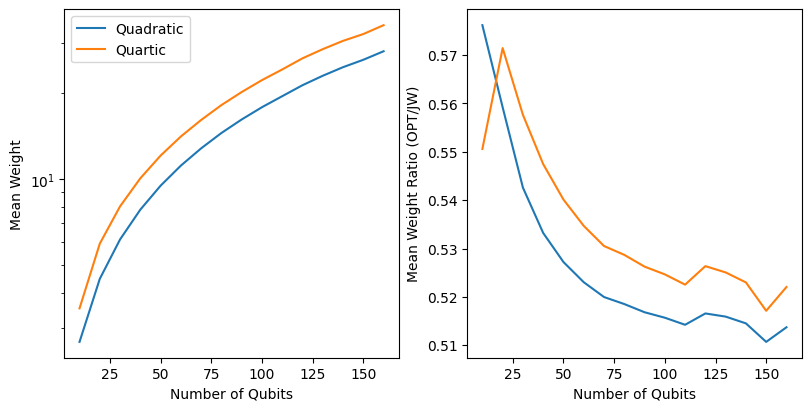

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)

axs[0].plot(num_qubits, quadratic_weights, label="Quadratic")
axs[0].plot(num_qubits, quartic_weights, label="Quartic")
axs[0].set_xlabel("Number of Qubits")
axs[0].set_ylabel("Mean Weight")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(num_qubits, quadratic_weights/quadratic_weights_jw, label="Quadratic")
axs[1].plot(num_qubits, quartic_weights/quartic_weights_jw, label="Quartic")
axs[1].set_xlabel("Number of Qubits")
axs[1].set_ylabel("Mean Weight Ratio (OPT/JW)")
# axs[1].legend()

We find that the weight of the optimized mappings seems to scale asymptotically logarithmically, which is at least plausible given that a logarithmic mapping exists in the form of Bravyi-Kitaev. 

This observation leads to a more sophisticated approach: Instead of starting our optimization based on the Majorana strings of the JW mapping, we immediately depart from the more resource-efficient BK mapping.

### Locality Analysis starting from BK mapping

We now repeat the same analysis, but instead start from the BK mapping. 

In [ ]:
quadratic_weights = []
quartic_weights = []

quadratic_weights_bk = []
quartic_weights_bk = []

num_qubits = list(range(10, 101, 5))

for N in num_qubits:

    print(N)

    x, z, _ = bk_majoranas(N)

    quadratic_weights_bk.append(quadratic_term_mean_weight(x, z))
    quartic_weights_bk.append(quartic_term_mean_weight(x, z))

    x, z, energies, energy_opt = anneal(x, z, explore=spread_node, energy=quadratic_term_mean_weight, cooling_rate=0.9999)
    
    quadratic_weights.append(energy_opt)
    quartic_weights.append(quartic_term_mean_weight(x, z))

In [85]:
### Storing the results here for the optimizations based on BK to avoid running the cell above every time

num_qubits = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

quadratic_weights_bk = [3.111111111111111, 3.4380952380952383, 4.368421052631579, 4.72, 4.905747126436782, 5.470588235294118, 5.87948717948718, 6.177777777777778, 6.32734693877551, 6.48956228956229, 6.526553672316385, 6.6625, 7.118426501035197, 7.414414414414415, 7.570253164556962, 7.773669467787115, 7.89063670411985, 7.980515117581187, 8.058787878787879]
quartic_weights_bk = [4.276190476190476, 4.672527472527473, 6.355830753353973, 6.839525691699604, 7.217588031381135, 8.432085561497326, 8.951504540978226, 9.35481056411289, 9.651046461137646, 9.959818797554647, 10.092261630112686, 10.459704005671748, 11.35812279486746, 11.816953391747912, 11.97388307894637, 12.31131996730517, 12.460217048438668, 12.552221501502256, 12.78760463885648]

quadratic_weights = [2.7555555555555555, 3.419047619047619, 3.8947368421052633, 4.48, 4.793103448275862, 4.99327731092437, 5.351282051282051, 5.715151515151515, 6.0253061224489795, 6.214814814814815, 6.388700564971751, 6.506730769230769, 6.5950310559006216, 6.785945945945946, 7.030063291139241, 7.20952380952381, 7.414481897627965, 7.60515117581187, 7.753939393939394]
quartic_weights = [3.742857142857143, 4.863003663003663, 5.786171310629515, 6.73897233201581, 7.210509031198686, 7.614438502673797, 8.36931830616041, 9.0547065337763, 9.445175857577073, 9.643846300450074, 9.943211623447866, 10.230464965142385, 10.48035162150519, 10.92169649101156, 11.38463751438435, 11.742288687440888, 12.129548878948336, 12.40121122836335, 12.487079420334206]

0.041244069872592326


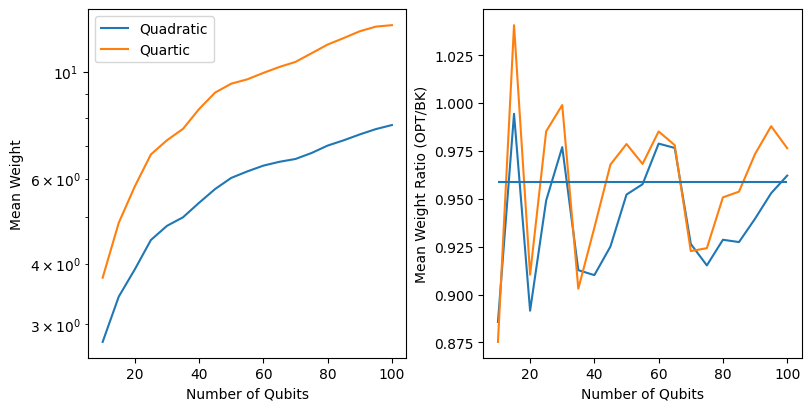

In [93]:
quadratic_weights = np.array(quadratic_weights)
quartic_weights = np.array(quartic_weights)

quadratic_weights_bk = np.array(quadratic_weights_bk)
quartic_weights_bk = np.array(quartic_weights_bk)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), constrained_layout=True)

axs[0].plot(num_qubits, quadratic_weights, label="Quadratic")
axs[0].plot(num_qubits, quartic_weights, label="Quartic")
axs[0].set_xlabel("Number of Qubits")
axs[0].set_ylabel("Mean Weight")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(num_qubits, quadratic_weights/quadratic_weights_bk, label="Quadratic")
axs[1].plot(num_qubits, quartic_weights/quartic_weights_bk, label="Quartic")
axs[1].set_xlabel("Number of Qubits")
axs[1].set_ylabel("Mean Weight Ratio (OPT/BK)")

mean = np.mean(quartic_weights/quartic_weights_bk)

axs[1].hlines(y=mean, xmin=num_qubits[0], xmax=num_qubits[-1])
# axs[1].legend()
print(1-mean)